In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models # PyTorch의 이미지 및 데이터셋 관련 기능 가져오기
import matplotlib.pyplot as plt
import os # 파일 및 디렉토리 관리를 위한 os 모듈 가져오기
import torch # PyTorch 라이브러리 가져오기
from sklearn.model_selection import train_test_split # 데이터를 훈련 및 테스트 세트로 분할하기 위한 모듈 가져오기
from torch.utils.data import DataLoader, Subset # 데이터 로딩 및 샘플링을 위한 모듈 가져오기
import torchvision.transforms as transforms # 이미지 변환을 위한 torchvision.transforms 모듈 가져오기
import torchvision.datasets as datasets # torchvision.datasets 모듈 가져오기
import numpy as np # 배열 및 행렬 작업을 위한 라이브러리
import cv2
import random


In [5]:
root_dir = "./four_genre_posters_updated_last"

In [4]:
root_dir = "./four_genre_posters_updated"
class_labels = ['action', 'comedy', 'horror', 'romance']
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff']
crop_size = 100

# 이미지 크롭 함수
def crop_image(image, crop_size):
    height, width = image.shape[:2]
    center_x = width // 2
    center_y = height // 2
    x1 = center_x - crop_size // 2
    x2 = center_x + crop_size // 2
    y1 = center_y - crop_size // 2
    y2 = center_y + crop_size // 2
    return image[y1:y2, x1:x2]
# 이미지 수평 뒤집기 함수
def flip_image(image, flip_code):
    return cv2.flip(image, flip_code)
# 이미지 회전 함수
def rotate_image(image, angle):
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, matrix, (width, height))
    return rotated_image

# 데이터셋을 순회하면서 이미지 크롭 및 처리 수행
for class_label in class_labels:
    class_dir = os.path.join(root_dir, class_label)
    os.makedirs(class_dir, exist_ok=True)

    for image_file in os.listdir(class_dir):
        if os.path.splitext(image_file)[1].lower() not in image_extensions:
            continue

        image_path = os.path.join(class_dir, image_file)
        image = cv2.imread(image_path)

        # 왼쪽으로 15도 회전한 이미지
        rotated_left_image = rotate_image(image, -15)
        cv2.imwrite(os.path.join(class_dir, f"rotated_left{image_file}"), rotated_left_image)

        # 오른쪽으로 15도 회전한 이미지
        rotated_right_image = rotate_image(image, 15)
        cv2.imwrite(os.path.join(class_dir, f"rotated_right{image_file}"), rotated_right_image)

        # 좌우 반전
        flipped_horizontal_image = flip_image(image, 1)
        cv2.imwrite(os.path.join(class_dir, f"flipped_horizontal{image_file}"), flipped_horizontal_image)

        # 크롭된 이미지 저장
        cropped_image = crop_image(image, crop_size)
        cv2.imwrite(os.path.join(class_dir, f"cropped{image_file}"), cropped_image)

In [6]:
# 이미지 불러오기&전처리

# 이미지 전처리를 위한 변환 정의
transform2 = transforms.Compose([
    transforms.Resize((224, 224)), # 이미지 크기를 224x224로 조정
    transforms.ToTensor() # 이미지를 텐서 형식으로 변환
])

# 데이터셋 불러오기
movie_dataset = datasets.ImageFolder(root=root_dir, transform=transform2)
# 위 경로에서 이미지 폴더를 불러와서, 이미지 전처리를 적용하여 데이터셋으로 생성

# DataLoader를 사용하여 이미지 데이터를 배치 단위로 불러올 수 있음
movie_data_loader = torch.utils.data.DataLoader(movie_dataset, batch_size=1, shuffle=False)
# 데이터셋을 배치 크기가 1인 DataLoader로 불러오기 (이미지를 하나씩 처리)

# 이미지 데이터를 NumPy 배열로 변환하고 평균과 표준편차를 계산
pixel_values = [] # 픽셀 값 배열 초기화
for images, _ in movie_data_loader: # DataLoader에서 이미지와 라벨을 하나씩 가져옴
    pixel_values.append(images.numpy())

pixel_values = np.concatenate(pixel_values, axis=0) # 리스트를 하나의 배열로 합침

# 픽셀 값의 평균과 표준편차 계산
mean = np.mean(pixel_values, axis=(0, 2, 3)) # 픽셀 값의 평균 계산
std = np.std(pixel_values, axis=(0, 2, 3)) # 픽셀 값의 표준편차 계산

print("평균:", mean) # 계산된 평균 출력
print("표준편차:", std) # 계산된 표준편차 출력

평균: [0.42423576 0.36692703 0.34444514]
표준편차: [0.32699022 0.30772167 0.29935703]


In [7]:
# myResNet 클래스 정의
class myResNet(nn.Module):
  def __init__(self):
    super(myResNet, self).__init__() # 부모 클래스의 초기화 함수 호출
    # ResNet18 모델 로드
    self.resnet = models.resnet18(weights=None) # 사전 학습된 ResNet18 모델을 불러와서 self.resnet에 저장
    # 출력 레이어를 클래스 수에 맞게 조정
    num_ftrs = self.resnet.fc.in_features 
    self.resnet.fc = nn.Linear(num_ftrs, 10) # 최종 출력 레이어의 입력 피처 개수를 가져와서 num_ftrs에 저장

  # forward 메서드 정의
  def forward(self, x):
    return self.resnet(x) # 입력 데이터 x를 ResNet18 모델에 전달하여 출력을 반환

In [9]:
# 이미지 train/test 분할
# 이미지 파일이 있는 디렉토리의 경로를 설정
# root_dir = "./four_genre_posters_updated" 

# 이미지 전처리를 위한 변환을 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)), # 이미지 크기를 224x224로 조정
    transforms.ToTensor(), # 이미지를 텐서 형태로 변환 
    transforms.Normalize(mean=[0.42423576, 0.36692703, 0.34444514],  # 이미지의 픽셀값을 정규화 (평균)
                         std=[0.32699022, 0.30772167, 0.29935703])  # 이미지의 픽셀값을 정규화 (표준편차)
]) 

# 데이터셋을 불러옵니다.
movie_dataset = datasets.ImageFolder(root=root_dir, transform=transform) # root_dir 디렉토리에서 이미지 데이터를 불러와서 movie_dataset에 저장

# 각 라벨의 이미지 수를 세고, 라벨별로 비율을 맞춰서 훈련 및 테스트 데이터를 분할
labels_count = {label: len([item for item in movie_dataset.targets if item == movie_dataset.class_to_idx[label]]) for label in movie_dataset.class_to_idx}
# 각 라벨에 대해 이미지 수를 세어서 labels_count 딕셔너리에 저장

train_indices = []
test_indices = []

for label, count in labels_count.items():
    # 각 라벨에 해당하는 이미지의 인덱스를 찾아 indices에 저장
    indices = [idx for idx, target in enumerate(movie_dataset.targets) if target == movie_dataset.class_to_idx[label]]
    # 훈련 및 테스트 세트로 분할
    train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
    # 훈련 및 테스트 세트의 인덱스를 각각 train_indices와 test_indices에 추가
    train_indices.extend(train_idx)
    test_indices.extend(test_idx)
    


# Subset을 사용하여 훈련 및 테스트 데이터를 생성
train_dataset = Subset(movie_dataset, train_indices)
test_dataset = Subset(movie_dataset, test_indices)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # 훈련 데이터를 배치 단위로 불러오는 DataLoader 생성 (배치 크기: 180, 셔플링 수행)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False) # 테스트 데이터를 배치 단위로 불러오는 DataLoader 생성 (배치 크기: 1000, 셔플링 수행 안 함)

In [10]:
# 각 라벨별 훈련 데이터셋과 테스트 데이터셋의 이미지 수 출력하여 분할 확인
print("라벨별 훈련 데이터셋 이미지 수:")
for label, count in labels_count.items(): # labels_count 딕셔너리에서 각 라벨과 이미지 수를 가져와 반복
    # 해당 라벨에 대한 훈련 데이터셋의 이미지 수 계산
    train_count = sum([1 for idx in train_indices if movie_dataset.targets[idx] == movie_dataset.class_to_idx[label]])
    print(f"{label}: {train_count}")
print("\n라벨별 테스트 데이터셋 이미지 수:")
for label, count in labels_count.items():  # labels_count 딕셔너리에서 각 라벨과 이미지 수를 가져와 반복
    # 해당 라벨에 대한 테스트 데이터셋의 이미지 수 계산
    test_count = sum([1 for idx in test_indices if movie_dataset.targets[idx] == movie_dataset.class_to_idx[label]])
    print(f"{label}: {test_count}")

라벨별 훈련 데이터셋 이미지 수:
Action: 1344
Comedy: 1204
Horror: 1432
Romance: 1240

라벨별 테스트 데이터셋 이미지 수:
Action: 336
Comedy: 301
Horror: 358
Romance: 310


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

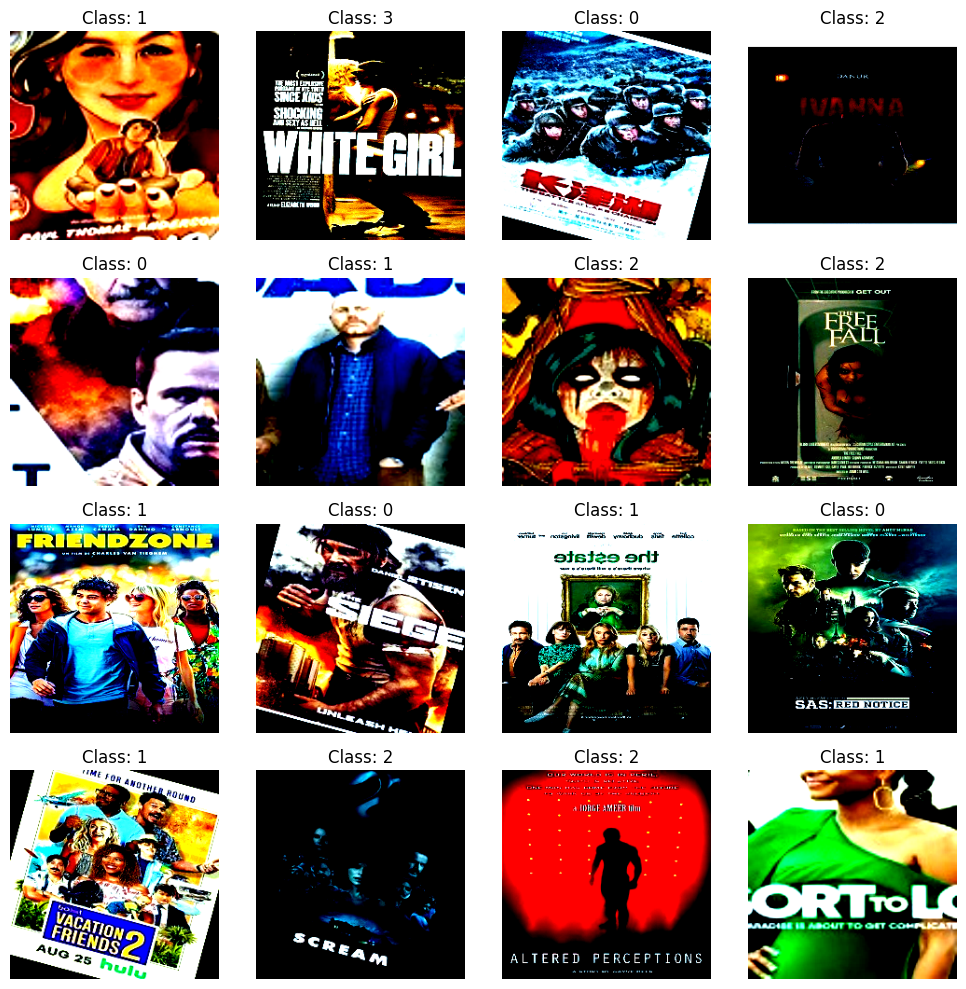

In [11]:
# train 데이터셋 이미지 일부 랜덤 시각화
# train_loader에서 반복하여 이미지와 레이블을 가져와서 시각화
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.ravel()  # 다차원 배열을 1차원 배열로 펼쳐서 반복문에서 사용할 수 있도록 함

for i, (images, labels) in enumerate(train_loader): # train_loader에서 이미지와 레이블을 가져와 반복
    for j in range(len(images)):
        index = i * len(images) + j  # 전체 인덱스 계산
        if index >= len(axes):  # 축 배열을 벗어나면 루프 종료
            break
        ax = axes[index]
        ax.imshow(images[j].permute(1, 2, 0))  # 이미지의 차원을 변경하여 imshow에 적합한 형식으로 변환
        ax.set_title(f"Class: {labels[j]}") # 현재 이미지의 레이블을 제목으로 설정
        ax.axis('off') # 축 비활성화

plt.tight_layout() # 그래프 간격을 조정하여 레이블이 겹치지 않도록 함
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

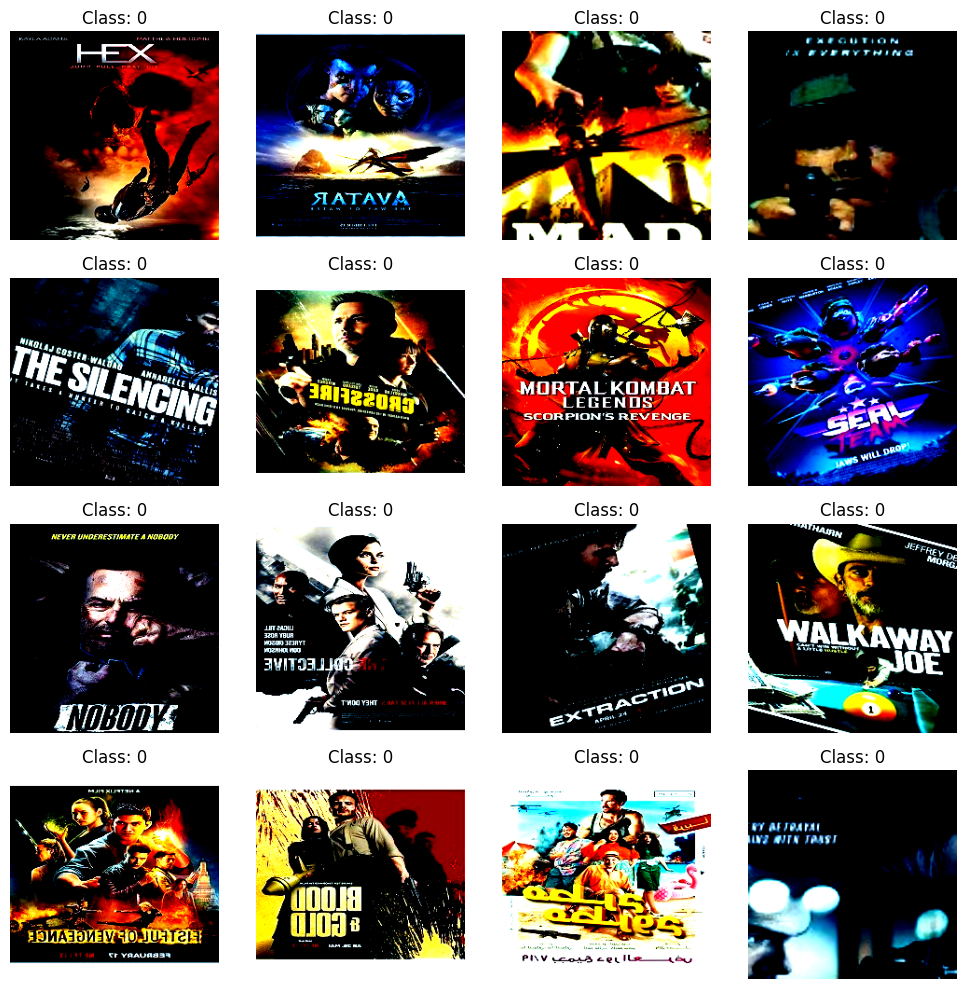

In [12]:
# test_loader 데이터셋 이미지 일부 랜덤 시각화
# test_loader 반복하여 이미지와 레이블을 가져와서 시각화
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.ravel() # 다차원 배열을 1차원 배열로 펼쳐서 반복문에서 사용할 수 있도록 함

for i, (images, labels) in enumerate(test_loader): # test_loader에서 이미지와 레이블을 가져와 반복
    for j in range(len(images)): # 이미지의 수만큼 반복
        index = i * len(images) + j  # 전체 인덱스 계산
        if index >= len(axes):  # 축 배열을 벗어나면 루프 종료
            break
        ax = axes[index]  # 현재 인덱스에 해당하는 축을 가져옴
        ax.imshow(images[j].permute(1, 2, 0))  # 이미지의 차원을 변경하여 imshow에 적합한 형식으로 변환
        ax.set_title(f"Class: {labels[j]}") # 현재 이미지의 레이블을 제목으로 설정
        ax.axis('off') # 축 비활성화

plt.tight_layout()
plt.show()

In [13]:
# GPU를 사용할 수 있는지 확인
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("CUDA(GPU)를 사용합니다.")

else:
  device = torch.device("cpu")
  print("CUDA(GPU)를 사용할 수 없으므로, CPU를 사용합니다.")

CUDA(GPU)를 사용할 수 없으므로, CPU를 사용합니다.


In [14]:
# 모델 함수 정의
model = myResNet().to(device) # myResNet 모델을 선택한 장치로 이동
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss를 손실 함수로 사용
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # Adam 옵티마이저 사용, 가중치 감쇠 적용
# 손실과 정확도를 저장하기 위한 리스트 초기화
train_losses = []
test_losses = []
test_accuracies = []
train_accuracies = []

# 훈련 함수
def train(model, train_loader, optimizer, epoch):
    model.train() # 모델을 훈련 모드로 설정
    train_loss = 0 # 현재 에포크의 훈련 손실을 저장하기 위한 변수 초기화
    correct = 0  # 맞은 개수를 기록하기 위한 변수 초기화
    total = 0  # 전체 개수를 기록하기 위한 변수 초기화
    for data, target in train_loader: # 훈련 데이터로더 순회
        optimizer.zero_grad() # 그래디언트 초기화
        output = model(data) # 모델에 데이터를 입력하여 출력 계산
        loss = criterion(output, target) # 손실 계산
        train_loss += loss.item() # 현재 배치의 손실 누적
        loss.backward() # 역전파를 통해 그래디언트 계산
        optimizer.step()  # 옵티마이저를 사용하여 가중치 업데이트
        # 내부 정확도 계산
        _, predicted = torch.max(output.data, 1) # 가장 높은 값을 가진 인덱스 추출
        total += target.size(0) # 현재 배치의 데이터 개수 누적
        correct += (predicted == target).sum().item() # 맞은 개수 누적
    # 평균 훈련 손실 계산하고 리스트에 추가
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # 정확도를 계산하고 리스트에 추가
    train_accuracy = 100. * correct / total
    train_accuracies.append(train_accuracy)  # 내부 정확도 기록
    print(f'Epoch{epoch}, Training loss: {train_loss:.4f}, Training accuracy: {train_accuracy:.2f}%')

# 테스트 함수
def test(model, test_loader):
    model.eval() # 모델을 평가 모드로 설정
    test_loss = 0 # 테스트 손실을 저장하기 위한 변수 초기화
    correct = 0 # 맞은 개수를 기록하기 위한 변수 초기화
    with torch.no_grad(): # 그래디언트를 계산하지 않음 선언
        for data, target in test_loader: # 테스트 데이터로더 순회
            output = model(data) # 모델에 데이터를 입력하여 출력 계산
            test_loss += criterion(output, target).item() # 손실 계산하고 누적
            pred = output.argmax(dim=1, keepdim=True) # 가장 높은 값의 인덱스 추출
            correct +=pred.eq(target.view_as(pred)).sum().item() # 맞은 개수를 누적
        # 평균 테스트 손실, 정확도 계산하고 리스트에 추가
        test_loss /= len(test_loader)
        accuracy = 100. * correct / len(test_loader.dataset)
        test_losses.append(test_loss)
        test_accuracies.append(accuracy)
        print(f'Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [15]:
# 모델 실행
# 실행 동안 test_loss가 5번 이상 개선되지 않을 때 조기 종료됨.
best_loss = float('inf') # 최적의 검증 손실 초기화
no_improvement = 0 # 개선 없는 에포크 수 초기화
patience = 5 # 조기 종료를 위한 인내심 설정

for epoch in range(0, 50):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)
    
    # 검증 손실 계산
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
        test_loss /= len(test_loader)
        
        # 최저 검증 손실 업데이트 및 조기 종료 체크
        if test_loss < best_loss:
            best_loss = test_loss
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f'Early stopping at epoch {epoch}')
                break

Epoch0, Training loss: 1.2384, Training accuracy: 46.21%
Test loss: 1.1967, Accuracy: 44.75%
Epoch1, Training loss: 1.1274, Training accuracy: 49.96%
Test loss: 1.3352, Accuracy: 42.53%
Epoch2, Training loss: 1.0891, Training accuracy: 52.07%
Test loss: 1.7506, Accuracy: 47.51%
Epoch3, Training loss: 1.0603, Training accuracy: 54.35%
Test loss: 0.9703, Accuracy: 51.42%
Epoch4, Training loss: 1.0014, Training accuracy: 57.01%
Test loss: 1.0473, Accuracy: 47.89%
Epoch5, Training loss: 0.9902, Training accuracy: 58.64%
Test loss: 1.1615, Accuracy: 51.65%
Epoch6, Training loss: 0.9469, Training accuracy: 60.67%
Test loss: 1.1324, Accuracy: 57.85%
Epoch7, Training loss: 0.9053, Training accuracy: 62.26%
Test loss: 1.2730, Accuracy: 55.17%
Epoch8, Training loss: 0.8776, Training accuracy: 63.16%
Test loss: 1.0953, Accuracy: 53.41%
Early stopping at epoch 8


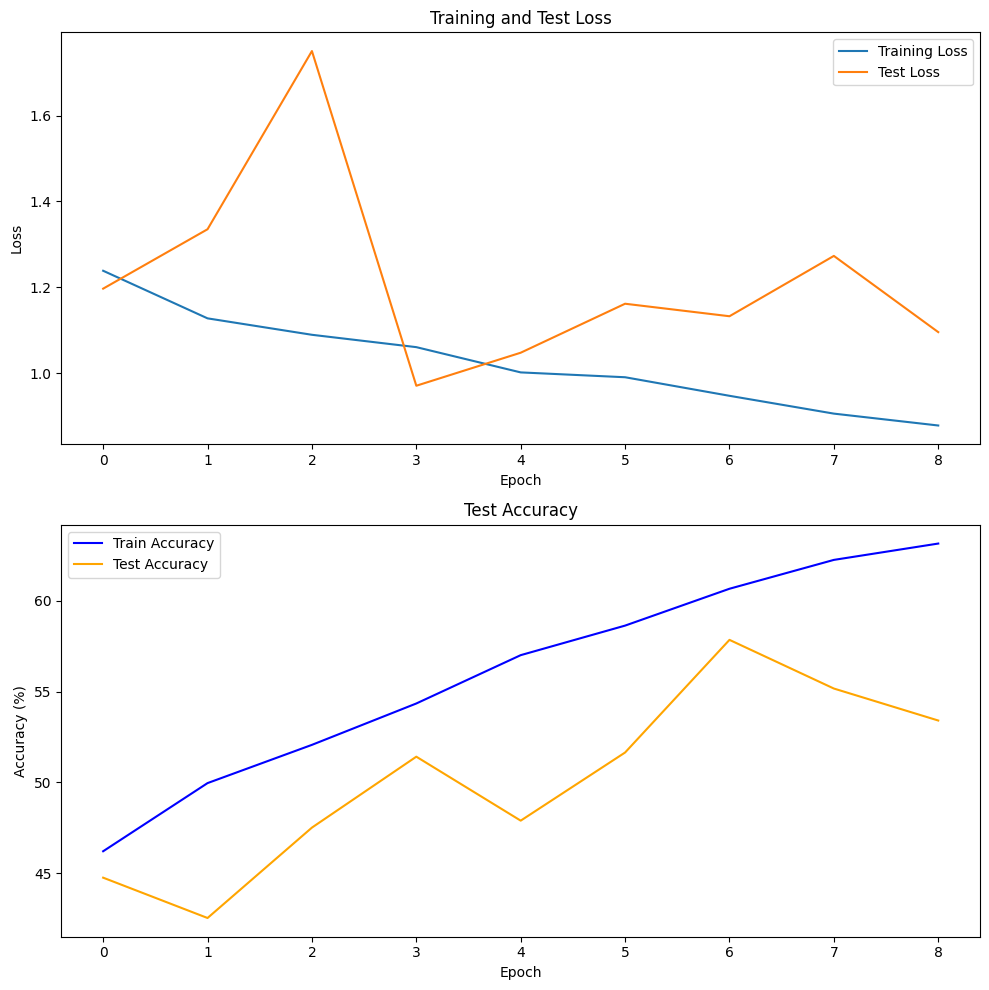

In [16]:
# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')
axs[1].plot(train_accuracies, label='Train Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Test Accuracy')
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

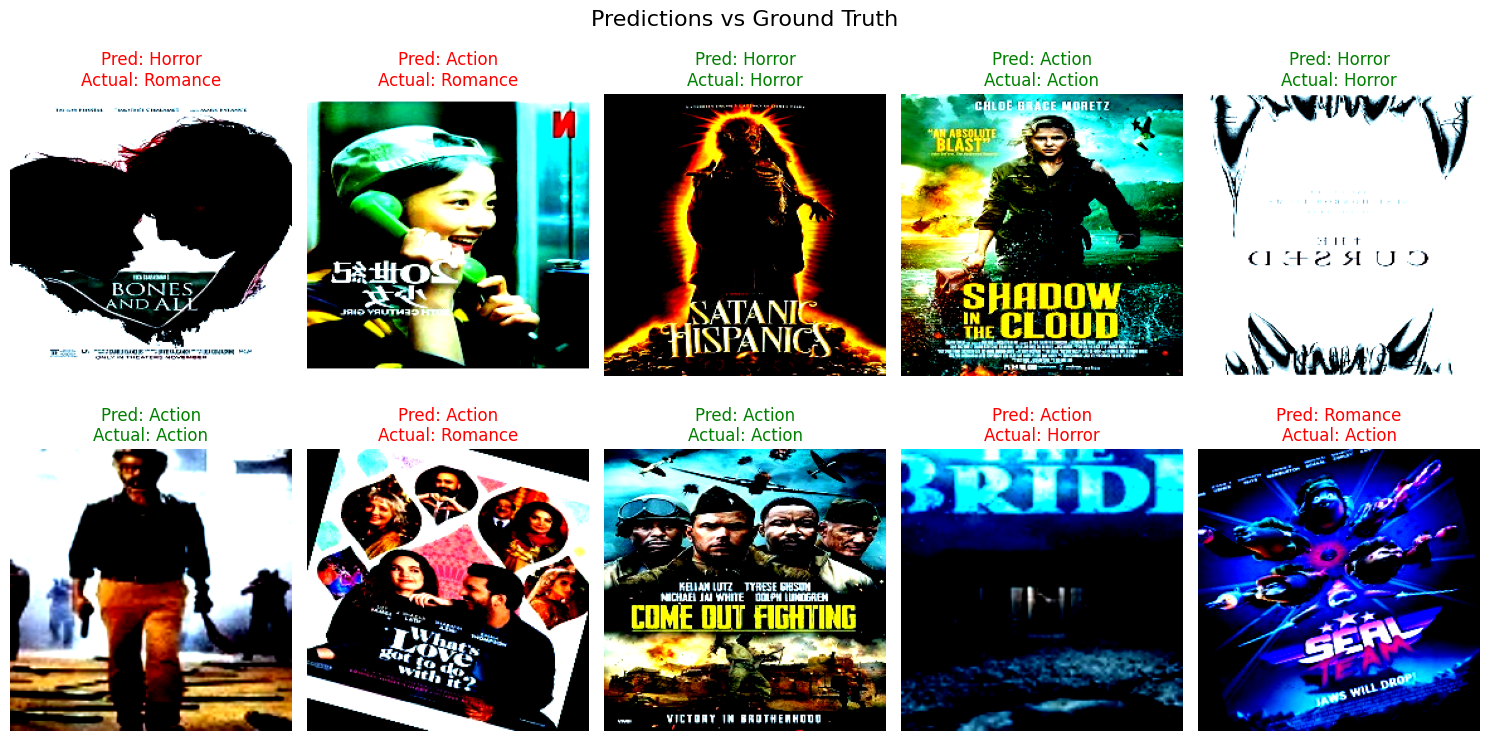

In [17]:
# 예측 결과 시각화
def visualize_predictions(model, test_loader, class_names, num_images=10):
    model.eval() # 모델을 평가 모드로 설정
    fig = plt.figure(figsize=(15, 8))
    fig.suptitle('Predictions vs Ground Truth', fontsize=16)
    
    # 무작위 이미지를 선택하기 위해 DataLoader에서 무작위로 이미지 선택
    random_indices = random.sample(range(len(test_loader.dataset)), num_images) # 무작위 인덱스 선택
    random_sampler = torch.utils.data.SubsetRandomSampler(random_indices) # 무작위 샘플러 생성
    random_loader = torch.utils.data.DataLoader(test_loader.dataset, batch_size=1, sampler=random_sampler) # DataLoader 생성
    
    current_row = 0  # 현재 행 번호 초기화
    current_col = 0  # 현재 열 번호 초기화
    
    with torch.no_grad(): # 그래디언트 계산 비활성 모드로 설정
        for i, (images, labels) in enumerate(random_loader):  # random_loader 사용
            if i == num_images: # 이미지 개수에 도달하면 루프 종료
                break
            
            outputs = model(images) # 모델에 이미지 전달하여 예측 수행
            _, predicted = torch.max(outputs, 1) # 예측된 클래스 인덱스 가져오기
            predicted = predicted.cpu().numpy() # 예측된 클래스 인덱스를 넘파이 배열로 변환
            images = images.cpu().numpy() # 이미지를 넘파이 배열로 변환
            labels = labels.cpu().numpy() # 라벨을 넘파이 배열로 변환
            
            for j in range(images.shape[0]):
                ax = fig.add_subplot((num_images + 4) // 5, 5, current_row * 5 + current_col + 1)  # 열 개수를 5로 고정
                ax.axis('off') # 축 숨김
                ax.set_title(f'Pred: {class_names[predicted[j]]}\nActual: {class_names[labels[j]]}', color=('green' if predicted[j] == labels[j] else 'red'))
                ax.imshow(np.transpose(images[j], (1, 2, 0))) # 이미지 표시
                
                current_col += 1  # 열 번호 증가
                if current_col >= 5:  # 현재 열이 5개 이상이면 다음 행으로 이동
                    current_row += 1
                    current_col = 0
    
    plt.tight_layout()
    plt.show()

# 시각화 함수 호출
class_names = ['Action', 'Comedy', 'Horror', 'Romance'] # 클래스 이름 리스트
num_images = 10
visualize_predictions(model, test_loader, class_names, num_images) # 시각화 함수 호출